In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import librosa
import numpy as np
from IPython.display import Audio
from pathlib import Path

# 1. Build Data Loading Function

## 1.1 Define Paths to Files

In [2]:
DATA_DIR = Path('data')
CAPUCHIN_FILE = DATA_DIR / 'Parsed_Capuchinbird_Clips' / 'XC3776-3.wav'
NOT_CAPUCHIN_FILE = DATA_DIR / 'Parsed_Not_Capuchinbird_Clips' / 'afternoon-birds-song-in-forest-0.wav'

### Capuchinbird Audio Example

In [3]:
print('Capuchin Bird')
Audio(CAPUCHIN_FILE)

Capuchin Bird


### Not Capuchinbird Audio Example

In [4]:
print('Not Capuchin Bird')
Audio(NOT_CAPUCHIN_FILE)

Not Capuchin Bird


## 1.2 Dataloading Function

In [5]:
def load_wav_16k_mono(file_path):
    audio, sr = librosa.load(file_path, sr=16e3, mono=True)

    return audio

## 1.3 Plot Wave

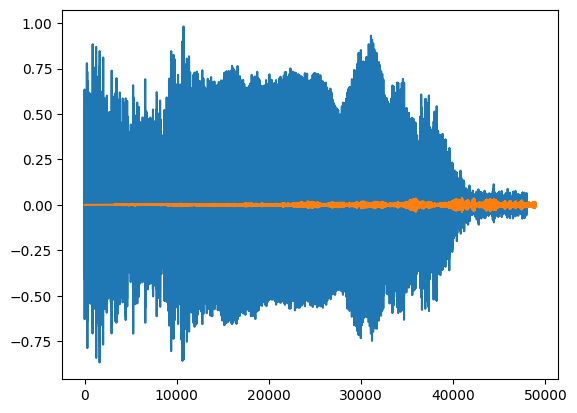

In [6]:
wave = load_wav_16k_mono(str(CAPUCHIN_FILE))
nwave = load_wav_16k_mono(str(NOT_CAPUCHIN_FILE))

plt.plot(wave)
plt.plot(nwave)
plt.show()

# 2. Create Tensorflow Dataset

## 2.1 Define Paths to Positive and Negative Data

In [7]:
POS_DATA = DATA_DIR / 'Parsed_Capuchinbird_Clips'
NEG_DATA = DATA_DIR / 'Parsed_NOT_Capuchinbird_Clips'

## 2.2 Create Tensorflow Datasets

In [8]:
pos_data = tf.data.Dataset.list_files(str(POS_DATA / '*.wav'))
neg_data = tf.data.Dataset.list_files(str(NEG_DATA / '*.wav'))

In [9]:
pos_data.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC574021-0.wav'

## 2.3 Add Labels to Datasets

In [10]:
pos_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(pos_data)))
pos_data = tf.data.Dataset.zip((pos_data, pos_labels))

neg_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg_data)))
neg_data = tf.data.Dataset.zip((neg_data, neg_labels))

data = pos_data.concatenate(neg_data)

# 3. Determine Average Length of a Capuchin Call

# 3.1 Calculate Wave Cycle Length

In [11]:
lengths = []
for file in os.listdir(POS_DATA):
    file_path = POS_DATA / file
    tensor_wave = load_wav_16k_mono(str(file_path))
    lengths.append(len(tensor_wave))

lengths = np.array(lengths)

### Mean, Min and Max Wave Cycle length


In [12]:
lengths.mean()

np.float64(54156.6866359447)

In [13]:
lengths.min()

np.int64(32000)

In [14]:
lengths.max()

np.int64(80000)

# 4. Signal Preprocessing

## 4.1 Preprocessing Function

In [15]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = np.zeros(48000 - wav.shape[0], dtype=np.float32)
    wav = np.concatenate((wav, zero_padding))

    wav_tf = tf.convert_to_tensor(wav)

    spectogram = tf.signal.stft(wav_tf, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    
    return spectogram, label


In [16]:
wav, label = preprocess(CAPUCHIN_FILE, 1)
print(wav)
print(wav.shape)

tf.Tensor(
[[[3.52045894e-03]
  [1.10064365e-03]
  [5.79682691e-03]
  ...
  [1.05204970e-04]
  [1.07770415e-04]
  [7.19130039e-05]]

 [[3.73296440e-03]
  [2.78363517e-03]
  [3.54823540e-03]
  ...
  [8.40767389e-05]
  [8.47465781e-05]
  [2.41249800e-05]]

 [[2.83007324e-03]
  [1.05618639e-03]
  [9.61456448e-03]
  ...
  [1.82133081e-04]
  [1.61412041e-04]
  [7.81565905e-05]]

 ...

 [[3.71337682e-03]
  [6.77361852e-03]
  [1.34945642e-02]
  ...
  [1.83114855e-04]
  [8.21828726e-05]
  [1.62087381e-04]]

 [[6.66413456e-04]
  [3.54612595e-03]
  [1.09554101e-02]
  ...
  [4.12740366e-04]
  [1.53909612e-04]
  [5.86472452e-05]]

 [[5.15407883e-03]
  [4.53031436e-03]
  [5.70574310e-03]
  ...
  [2.90418422e-04]
  [1.02663958e-04]
  [6.18267804e-05]]], shape=(1491, 257, 1), dtype=float32)
(1491, 257, 1)


## 4.3 Test the Function and Visualizate spectogram

In [17]:
pos_file_path, pos_label = pos_data.shuffle(buffer_size=10000).as_numpy_iterator().next()
print(pos_file_path)
print(pos_label)

b'data\\Parsed_Capuchinbird_Clips\\XC600460-4.wav'
1.0


In [18]:
neg_file_path, neg_label = neg_data.shuffle(buffer_size=10000).as_numpy_iterator().next()
print(neg_file_path)
print(neg_label)

b'data\\Parsed_NOT_Capuchinbird_Clips\\crickets-chirping-crickets-sound-7.wav'
0.0


In [19]:
pos_spectogram, pos_label = preprocess(pos_file_path, pos_label)
neg_spectogram, neg_label = preprocess(neg_file_path, neg_label)

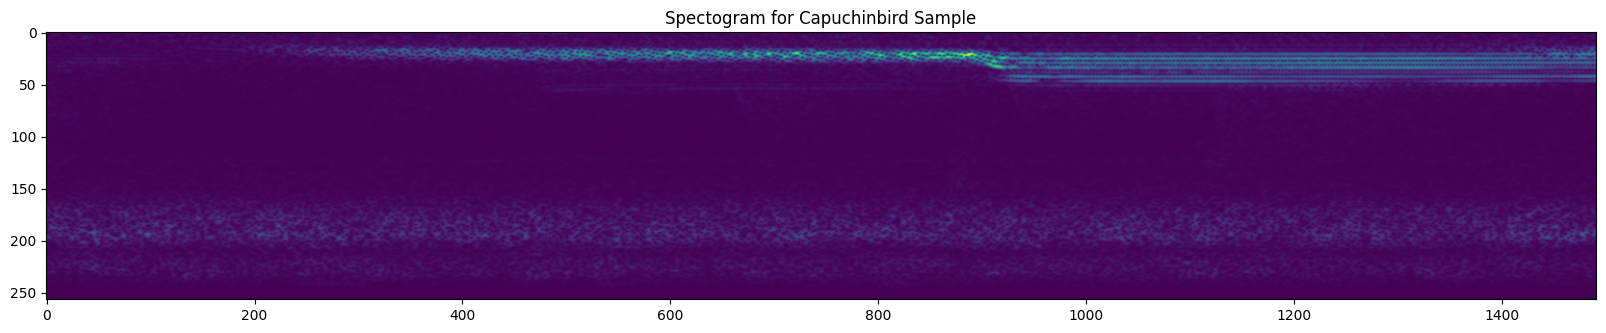

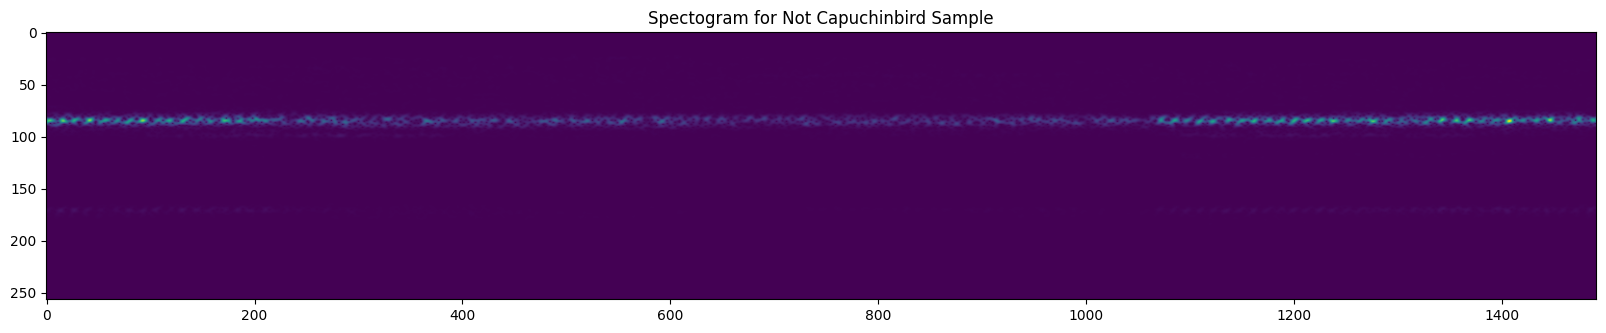

In [20]:
plt.figure(figsize=(20, 15))
plt.imshow(tf.transpose(pos_spectogram)[0])
plt.title('Spectogram for Capuchinbird Sample')
plt.show()

plt.figure(figsize=(20, 15))
plt.imshow(tf.transpose(neg_spectogram)[0])
plt.title('Spectogram for Not Capuchinbird Sample')
plt.show()

# 5. Create Training and Testing Partitions

## 5.1 Create a Tensorflow Data Pipeline

In [21]:
def make_generator(data):
    def generator():
        for file_path, label in data.as_numpy_iterator():
            yield preprocess(file_path, label)
    return generator    

In [22]:
data_generator = make_generator(data)
output_signature = (
    tf.TensorSpec(shape=(1491, 257, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

data = tf.data.Dataset.from_generator(data_generator, output_signature=output_signature)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## 5.2 Split Into Tranining and Testing Partitions

In [23]:
train = data.take(36)
test = data.skip(36).take(15)

## 5.3 Test One Batch

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(16, 1491, 257, 1)

# 6. Build Deep Learning Model

## 6.1 Load Tensorflow Dependencies

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D

## 6.2 Build Sequential Model, Compile and View Summary

In [27]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\miki0\Desktop\Projects\Audio\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

## 6.3 Fit Model

In [29]:
hist = model.fit(train, epochs=20, validation_data=test, verbose=1)

Epoch 1/20
     36/Unknown 24s 640ms/step - loss: 0.6803 - precision: 0.1750 - recall: 0.1497

c:\Users\miki0\Desktop\Projects\Audio\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 722ms/step - loss: 0.6798 - precision: 0.1751 - recall: 0.1462 - val_loss: 0.6304 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 702ms/step - loss: 0.5657 - precision: 0.4794 - recall: 0.0336 - val_loss: 0.4545 - val_precision: 0.8919 - val_recall: 0.5323
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 685ms/step - loss: 0.4100 - precision: 0.9192 - recall: 0.5519 - val_loss: 0.4115 - val_precision: 0.9167 - val_recall: 0.5077
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 686ms/step - loss: 0.4756 - precision: 0.7692 - recall: 0.4947 - val_loss: 0.3799 - val_precision: 0.9688 - val_recall: 0.4921
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 684ms/step - loss: 0.4343 - precision: 0.9054 - recall: 0.4666 - val_loss: 0.4116 - val_precision: 0.9524 - val_recall: 0.5333
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 687ms/step - loss: 0.3879 - precision: 0.8649 - recall: 0.5434 - val_loss: 0.3098 - val_precision: 1.0000 - val_reca

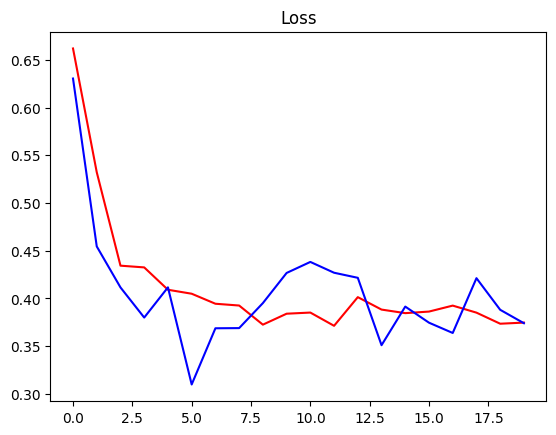

In [30]:
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.title('Loss')
plt.show()

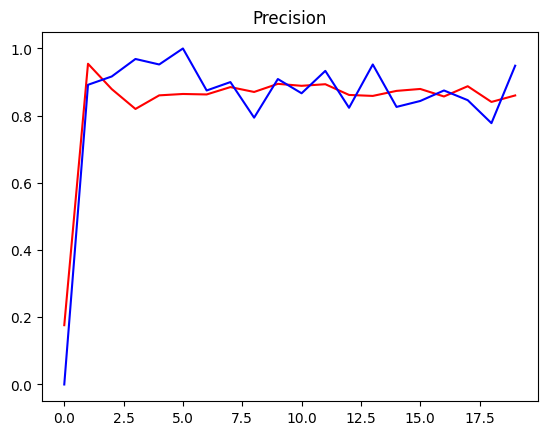

In [31]:
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.title('Precision')
plt.show()

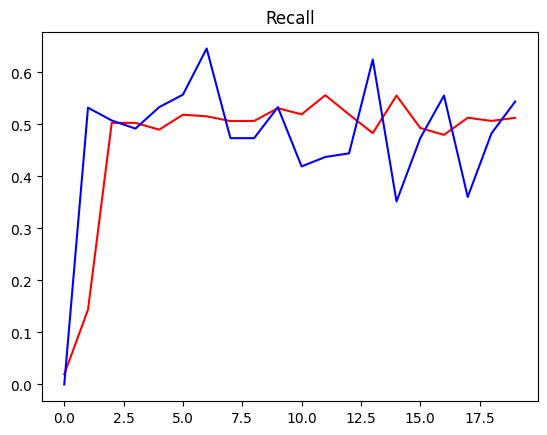

In [32]:
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.title('Recall')
plt.show()

# 7. Make a Prediction on a Single Clip 

## 8.1 Get One Batch and Make a Prediction

In [57]:
X_test, y_test = test.as_numpy_iterator().next()

In [58]:
y_scores = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


In [59]:
y_preds = (y_scores > 0.5).astype(int)

In [60]:
y_preds

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [61]:
y_test

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

# 8. Build Forest Parsing Functions

## 8.1 Load up MP3s

In [38]:
def load_mp3_16k_mono(file_path):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    sr = np.int64(sr)

    audio = librosa.resample(audio, orig_sr=sr, target_sr=16e3)
    return audio

In [39]:
FOREST_DIR = DATA_DIR / 'Forest Recordings'
FOREST_FILE_PATH = FOREST_DIR / 'recording_00.mp3'

wav = load_mp3_16k_mono(FOREST_FILE_PATH)

In [40]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [41]:
len(audio_slices)

60

In [42]:
samples, index = audio_slices.as_numpy_iterator().next()

In [43]:
samples.shape

(1, 48000)

## 8.2 Build a Function to Convert Clips into Windowed Spectograms

In [44]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    sample = sample[:48000]

    sample_tf = tf.convert_to_tensor(sample)

    spectogram = tf.signal.stft(sample_tf, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    
    return spectogram


In [45]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [63]:
y_scores = model.predict(audio_slices)
y_preds = (y_scores > 0.5).astype(int)
y_preds

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [69]:
from itertools import groupby

y_preds = [key for key, group in groupby(y_preds)]
calls = np.sum(y_preds)
calls

np.int64(5)